In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# dataset definition
class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        self.types_count = []
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            self.types_count.append(len(files))
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
        self.sample_weights = [1/self.types_count[label] for label in self.types]
    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).find("mark")
        for x in xml_data:
            if(x.tag=='svg'):
                encoded = str(x.text)
                poly_data = json.loads(x.text)
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        mask = np.zeros(np.shape(im))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        
        # add mask 
        for polygon in poly_data:
            xs = []
            ys = []
            for point in polygon["points"]:
                xs.append(point["x"])
                ys.append(point["y"])
            contour = np.concatenate((np.expand_dims(xs, 1), np.expand_dims(ys, 1)), axis=1)
            cv2.fillPoly(mask, pts = [contour], color =(1, 1, 1))
        
        mask = cv2.resize(mask, dsize=(300, 300), interpolation=cv2.INTER_LINEAR)
        
        
        
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
        im = np.ascontiguousarray(im)

        #plt.figure()
        #plt.imshow(im)

        transforms = Compose([ToTensor()])
        mask = transforms(mask)
        im = transforms(im)
        
        im = im * mask
        
        im = im.type(torch.FloatTensor)
        
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types, "name": str(im_name)}
        return sample

In [3]:
# Dataset creation
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 1,
    #"shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train, sampler=torch.utils.data.WeightedRandomSampler(training_set.sample_weights, len(training_set.cases), replacement=True))



/home/mihail/OneDrive/work/projects/thyroid/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/data/train/malign
number of data items:73
/home/mihail/OneDrive/work/projects/thyroid/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/data/train/malign
number of data items:73


In [4]:
all_ims = np.zeros((300, 300, len(training_generator)))
c = 0
for data in training_generator:
    all_ims[:, :, c] = data["image"][0, 0, :, :].detach().numpy()
    print(data["labels"])
    c += 1


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]],
       dtype=torch.float64)
tensor([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]],
       dtype=torch.float64)
tensor([[0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]],
       dtype=torch.float64)
tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]],
       dtype=torch.float64)
tensor([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.]],
       dtype=torch.float64)
tensor([[0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]],
       dtype=torch.float64)
tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]],
       dtype=torch.float64)
tensor([[0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.]],
       dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]],
       dtype=torch.float64)
tensor([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]]

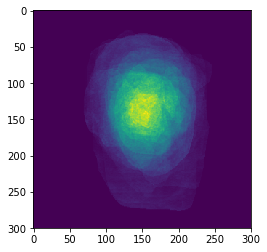

In [5]:
avg_im = np.mean(all_ims, axis=2)
plt.imshow(avg_im)

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10, svd_solver='arpack')
X = np.reshape(all_ims, (300*300, len(training_generator))).T
avg = np.mean(X, axis=0)
pca.fit(X)


PCA(n_components=10, svd_solver='arpack')

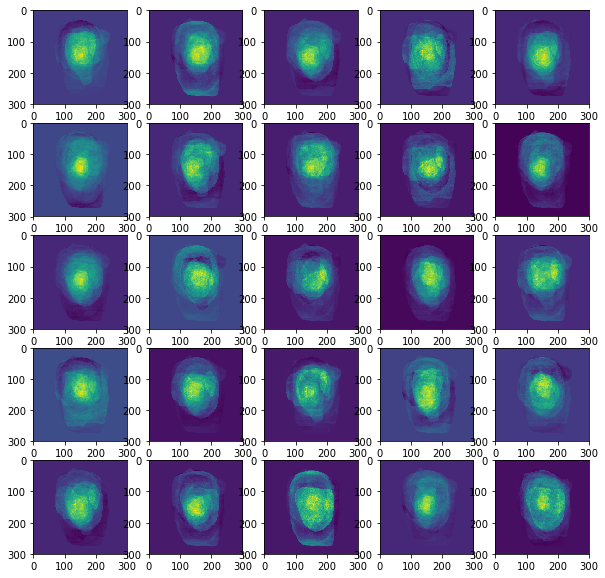

In [25]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    synthetic = pca.inverse_transform(np.random.randn(10,) * 2) 
    synthetic = np.reshape(synthetic, (300, 300))
    r, c = np.unravel_index(i, (5, 5))
    ax[r, c].imshow(synthetic)
